Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [397]:
import logging
from pprint import pprint, pformat
from typing import Callable
from collections import namedtuple
import random
from copy import deepcopy
from random import gauss
import matplotlib.pyplot as plt

## The *Nim* and *Nimply* classes

In [398]:
NUM_ROWS = 5
K = None
NUM_MATCHES = 300

In [399]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [400]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        # Initialize the Nim object with given number of rows and an optional maximum object limit
        self._rows = [i * 2 + 1 for i in range(num_rows)]   # Create a list of odd numbers as row sizes
        self._k = k   # Store the maximum object limit

    def __bool__(self):
        # Return True if there are objects remaining in the game, False otherwise
        return sum(self._rows) > 0

    def __str__(self):
        # Return a string representation of the object
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        # Return the rows as a tuple
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        # Perform a nimming move by removing objects from a specified row
        row, num_objects = ply   # Unpack the tuple
        assert self._rows[row] >= num_objects   # Check if the specified row has enough objects
        assert self._k is None or num_objects <= self._k   # Check if the number of objects is within the maximum limit
        self._rows[row] -= num_objects   # Subtract the number of objects from the specified row



## Sample (and silly) startegies 

In [401]:

def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    # Select a row that has at least one object remaining
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    # Randomly choose a number of objects to remove from the selected row
    num_objects = random.randint(1, state.rows[row])
    # Create and return a Nimply object representing the chosen move
    return Nimply(row, num_objects)



In [402]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    # Generate a list of possible moves
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    # Select the move with the maximum number of objects from the lowest row
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))



In [403]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [404]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [405]:
# logging.getLogger().setLevel(logging.INFO)

# strategy = (optimal, pure_random)

# nim = Nim(5) # define the game with 5 rows
# logging.info(f"init : {nim}")
# player = 0
# while nim: # while the game is not over --> sum of all rows is not zero
#     ply = strategy[player](nim) # get the move from the player 0
#     logging.info(f"ply: player {player} plays {ply}")
#     nim.nimming(ply) # perform the move
#     logging.info(f"status: {nim}")
#     player = 1 - player
# logging.info(f"status: Player {player} won!")


In [406]:
def state_info(state: Nim) -> dict:
    info = dict()
    info["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) 
    ]
    info["active_rows_number"] = sum(o > 0 for o in state.rows)
    info["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    info["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    info["random_row"] = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    info["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in info["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    info["brute_force"] = brute_force

    return info

In [407]:
def evolved_strategy(genome: float) -> Callable:
    def adaptive(state: Nim) -> Nimply:
        data = state_info(state)

        if random.random() < genome:
            ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        else:
            ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))
        
        return ply
        
    
    
        # if genome > 0.66:
        #     ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        # elif  genome > 0.33:
        #     ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))
        # else: 
        #     ply = Nimply(data["random_row"], random.randint(1, state.rows[data["random_row"]]))
        # return ply

    return adaptive

In [408]:
def fitness(strategy: Callable) -> int:
    won = 0
    opponent = (strategy, gabriele)

    for _ in range(NUM_MATCHES):
        nim = Nim(NUM_ROWS)
        player = 0

        while nim:
            ply = opponent[player](nim)
            nim.nimming(ply)  # perform the move
            player ^= 1

        if player == 0:
            won += 1

    return won  # return the number of matches won

In [409]:
λ = 20
σ = 0.5




def generate_offsprings(offspring) -> list:
    
    offsprings = [np.clip(offspring + np.random.normal(0, σ), 0, 1) for _ in range(λ)]
    
    
    return offsprings



    

[(1.0, 280),
 (0.9900709929031346, 273),
 (1.0, 271),
 (0.9947428062064081, 270),
 (1.0, 264),
 (1.0, 259),
 (0.8953027437740726, 245),
 (0.7055010520001557, 233),
 (0.6635444463076534, 233),
 (0.6586327498451141, 233),
 (0.47214779800771867, 230),
 (0.4781642768853721, 228),
 (0.47508836104485286, 221),
 (0.2611058652391024, 210),
 (0.43248421564010153, 209),
 (0.0, 208),
 (0.27155644184352173, 202),
 (0.0, 198),
 (0.0, 182),
 (0.1956399786918685, 180)]
Best result for generation 1 is: (1.0, 280)
[(1.0, 278),
 (1.0, 275),
 (1.0, 273),
 (0.9537173929049251, 272),
 (1.0, 271),
 (1.0, 271),
 (1.0, 270),
 (1.0, 268),
 (1.0, 268),
 (1.0, 268),
 (1.0, 266),
 (1.0, 262),
 (0.8794983197516897, 254),
 (0.766036862011474, 246),
 (0.47069648582500534, 231),
 (0.5969011664565951, 231),
 (0.5206080224885625, 217),
 (0.45134197561439726, 211),
 (0.22525911433549617, 195),
 (0.11133141545473091, 190)]
Best result for generation 2 is: (1.0, 278)
[(1.0, 277),
 (1.0, 276),
 (1.0, 269),
 (0.972525558584

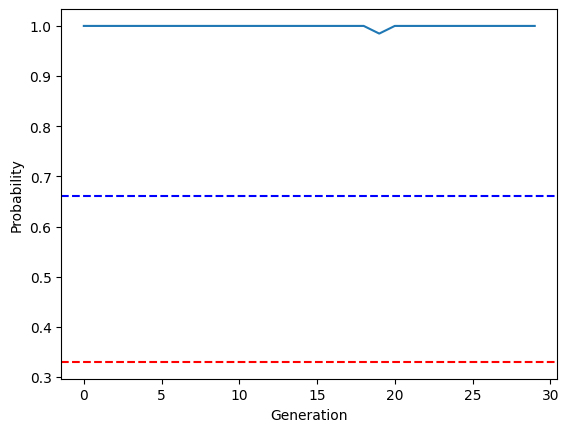

ValueError: x and y must have same first dimension, but have shapes (20,) and (30,)

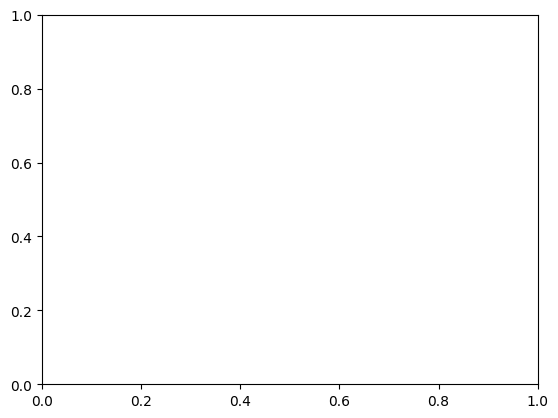

In [410]:


current_solution = 0.5
choosen_probability = list()
solutions_list = list()
stats = [0, 0]
for n in range(600 // λ):
    # offspring <- select λ random points mutating the current solution
    # print("Starting probability for generation", n+1, "is:", current_solution)
    offsprings = generate_offsprings(current_solution)
    
    # evaluate and select best
    evals = [(offspring, fitness(evolved_strategy(offspring))) for offspring in offsprings]
    
    for i in range(λ):
            if evals[i][1] > evals[λ-1][1]:
                stats[1] += 1    
    
    evals.sort(key=lambda x: x[1], reverse=True)
    pprint(evals)
    
    
    current_solution = evals[0][0]
    choosen_probability.append(current_solution)
    solutions_list.append(evals[0][1])
    
    
    
    print(f"Best result for generation {n+1} is:", evals[0])
    

plt.plot(range(len(choosen_probability)), choosen_probability)
plt.axhline(y=0.33, color='r', linestyle='--')
plt.axhline(y=0.66, color='b', linestyle='--')
plt.xlabel("Generation")
plt.ylabel("Probability")
plt.show()

plt.plot(range(600 // λ ) ,solutions_list)
plt.xlabel("Generation")
plt.ylabel("Number of wins")
plt.show()
    





# if state.k is None or o <= state.k
